## 0.0 Imports

In [1]:
%pip install pandas
%pip install scikit-learn
%pip install openpyxl
%pip install --upgrade pip
%pip install matplotlib
%pip install pycm==4.3
%pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from pycm import ConfusionMatrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
import tracemalloc
import time

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1.0 Leitura do conjunto de dados

In [2]:
ds = pd.read_excel('GPS_Data_Simplified_2D_Feature_Map.xlsx',  dtype = str)
ds

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output
0,6,1160.67140780005,-238359.543281858,491568,491568.000795082,-24660.2632931903,163521.78,170008.81,179294.97,178420.33,-17688.178,1158.4806,49.412529,0
1,6,1157.82780811118,-238363.921192484,491568.02,491568.020795096,-24683.4685202421,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0
2,6,1161.13593220979,-238368.638614547,491568.04,491568.040795112,-24706.6873571922,184442.36,193125.89,208228.02,-205198.3,35391.59,1157.6909,49.480145,0
3,6,1161.15661719479,-238373.391774656,491568.06,491568.060795128,-24729.9200394638,159812.45,169960.55,187550.72,187543,-1701.944,1161.1343,49.433769,0
4,6,1160.6908929619,-238378.127065742,491568.08,491568.080795144,-24753.1539994783,183557.66,191912.58,208403.5,208330.05,-5532.8999,1161.1759,49.39167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510525,4,-1113.336004,1949364.523,264109.58,264109.5735,114898.7034,90875.36719,104455.8516,99626.32031,-95613.48438,27990.45703,-1113.685547,43.05340958,0
510526,7,3542.882288,2823824.599,264109.58,264109.5706,-195707.189,139266.9219,133094.5938,144683.2656,-142087.5469,-27283.24023,3532.388916,46.4665451,0
510527,9,1205.18283,1298452.438,264109.58,264109.5757,-136011.0641,104211.4117,111445.296,125940.9297,-125705.6406,-9212.472557,2779.28833,47.58116531,3
510528,27,2814.03045,2298963.88,264109.58,264109.5723,-300750.7153,107693.0131,121277.7439,133731.1114,132020.7188,-21319.94265,2780.66748,46.21652603,3


### 1.1 Funções auxiliares

In [3]:
translated_names = {
    "TPR": "Probabilidade de detecção",
    "FPR": "Probabilidade de alarme falso",
    "PMD": "Probabilidade de detecção falsa",
    "TNR": "Especificidade",
    "ERR": "Taxa de Erro",
    "ACC": "Acurácia",
    "F1": "F1-Score",
    "MCC": "Coeficiente MCC",
    "PFA": "Probabilidade de alarme falso",
  }

def plot_performance_metrics(metrics, title):
  df = pd.DataFrame([metrics])
  df.round(2)
  df.columns = ["Train time", "Train peak memory",
                "Predict time", "Predict peak memory"]

  df = df.style.hide(axis='index').format(
    {"Train time": "{:.2f} ms",
     "Train peak memory": "{:.2f} MiB",
     "Predict time": "{:.2f} ms",
     "Predict peak memory": "{:.2f} MiB"})
  df = df.set_caption(title)

  return df

def benchmark(model, X_train, y_train, X_test):
    tracemalloc.start()
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    train_time = (t1 - t0) * 1000  # ms
    train_mem = peak / 1024 ** 2   # MiB

    tracemalloc.start()
    t0 = time.time()
    y_pred = model.predict(X_test)
    t1 = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    pred_time = (t1 - t0) * 1000  # ms
    pred_mem = peak / 1024 ** 2   # MiB

    metrics = {
        "train_time_ms": train_time,
        "train_peak_memory_MiB": train_mem,
        "predict_time_ms": pred_time,
        "predict_peak_memory_MiB": pred_mem
    }

    return metrics, y_pred


# function that receive a confusion matrix and return weighted metrics
def get_weighted_metrics(cm, metrics_to_show=["TPR", "FPR", "TNR", "ERR", "ACC", "F1", "MCC"]):
    classes = cm.classes
    metrics = {}
    metrics_weighted = {}
    counts = Counter(cm.actual_vector)
    total = len(cm.actual_vector)

    for metric in metrics_to_show:
      metrics.update({metric: list(cm.class_stat[metric].values())})

    metrics.update({"PMD": [1 - cm.TPR[c] for c in classes]})
    weights = np.array([counts.get(cls, 0) / total for cls in classes])
    
    for metric in metrics_to_show:
      values_per_class = np.array(list(cm.class_stat[metric].values()))

      weighted_values = np.sum(values_per_class * weights)
      metrics_weighted[metric] = weighted_values
    
    values_per_class = np.array(metrics["PMD"])
    metrics_weighted["PMD"] = np.sum(values_per_class * weights)

    return metrics_weighted

def print_weighted_metrics(metrics_weighted):
    data = [(translated_names.get(k, k), v) for k, v in metrics_weighted.items()]

    df = pd.DataFrame(data, columns=["Métrica", "Valor"], index=None)
    df["Valor"] = df["Valor"].map(lambda x: f"{x:.4f}")
    
    return df.style.hide(axis='index')


def plot_metrics_graphic(results, metrics_to_plot):
  algorithms = list(results.keys())
  first_metric_value = [results[alg][metrics_to_plot[0]] * 100 for alg in algorithms] 
  second_metric_value = [results[alg][metrics_to_plot[1]] * 100 for alg in algorithms] 

  x = np.arange(len(algorithms))
  width = 0.15
  gap = 0.05

  _, ax = plt.subplots()

  ax.bar(x - width/2 - gap/2, first_metric_value, width, label=translated_names.get(metrics_to_plot[0].upper(), metrics_to_plot[0].upper()), color='skyblue')
  ax.bar(x + width/2 + gap/2, second_metric_value, width, label=translated_names.get(metrics_to_plot[1].upper(), metrics_to_plot[1].upper()), color='lightgray')

  ax.set_ylabel('%', fontsize=12)
  ax.set_xticks(x)
  ax.set_xticklabels(algorithms, fontsize=10)
  ax.tick_params(axis='y', labelsize=10)
  ax.legend(
      loc='upper center',
      bbox_to_anchor=(0.5, -0.15),
      ncol=2,
      fontsize=9
  )

  ax.yaxis.grid(True, linestyle='--', alpha=0.6)
  plt.tight_layout()
  plt.show()


### 1.2 Extração das features e da classe


In [4]:
feature_columns = ["PRN","DO","PD","RX","TOW","CP","EC","LC","PC","PIP","PQP","TCD","CN0"]
X = ds[feature_columns].values
y = ds['Output'].values

ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510530 entries, 0 to 510529
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PRN     510530 non-null  object
 1   DO      510530 non-null  object
 2   PD      510530 non-null  object
 3   RX      510530 non-null  object
 4   TOW     510530 non-null  object
 5   CP      510530 non-null  object
 6   EC      510530 non-null  object
 7   LC      510530 non-null  object
 8   PC      510530 non-null  object
 9   PIP     510530 non-null  object
 10  PQP     510530 non-null  object
 11  TCD     510530 non-null  object
 12  CN0     510530 non-null  object
 13  Output  510530 non-null  object
dtypes: object(14)
memory usage: 54.5+ MB


### 1.3 Separação dos dados de treinamento e teste
> Separação foi de 70% do conjunto de dados para treino e 30% para testes


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1.4 Pre-processamento dos dados
**Utilização das seguintes técnicas:**

- _Standard Scaler_
- _Principal Component Analysis (PCA)_
- _Random Under Sampler_

----

- **Standard scaler:** visa padronizar o conjunto de dados.
- **PCA:** visa reduzir a dimensão do conjunto de dados.
- **Random Under Sampler:** faz o _undersampling_ do conjunto de dados, balanceando as classes, fazendo com que os dados das classes majoritárias sejam removidos até que se alcance um balanceamento com as classes minoritárias

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

rus = RandomUnderSampler(random_state=42)

X_train_res, y_train_res = rus.fit_resample(X_train_pca, y_train) # type: ignore

## 2. Treino e teste do K-NN

In [7]:
cl_sklearn = KNeighborsClassifier(n_neighbors=3)
metrics_knn, y_pred = benchmark(cl_sklearn, X_train_res, y_train_res, X_test_pca)

### 2.1 Métricas de desempenho do K-NN

In [8]:
cm = ConfusionMatrix(actual_vector=y_test,predict_vector=y_pred)

weighted_metrics_knn = get_weighted_metrics(cm)

print_weighted_metrics(weighted_metrics_knn)

Métrica,Valor
Probabilidade de detecção,0.7332
Probabilidade de alarme falso,0.0537
Especificidade,0.9463
Taxa de Erro,0.2104
Acurácia,0.7896
F1-Score,0.7619
Coeficiente MCC,0.5517
Probabilidade de detecção falsa,0.2668


### 2.2 Matriz de confusão

<Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

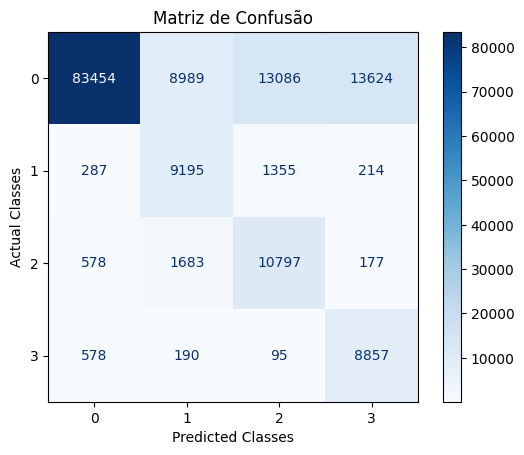

In [9]:
cm.plot(number_label=True, title="Matriz de Confusão", cmap=plt.cm.Blues) # type: ignore

## 3. Treino e teste do Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
metrics_rf, y_pred = benchmark(rf, X_train_res, y_train_res, X_test_pca)

### 3.1 Métricas de desempenho do Random Forest

In [11]:
cm_rf = ConfusionMatrix(actual_vector=y_test,predict_vector=y_pred)

weighted_metrics_rf = get_weighted_metrics(cm_rf)
print_weighted_metrics(weighted_metrics_rf)

Métrica,Valor
Probabilidade de detecção,0.9076
Probabilidade de alarme falso,0.0163
Especificidade,0.9837
Taxa de Erro,0.0649
Acurácia,0.9351
F1-Score,0.9136
Coeficiente MCC,0.8116
Probabilidade de detecção falsa,0.0924


### 3.2 Matriz de confusão

<Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

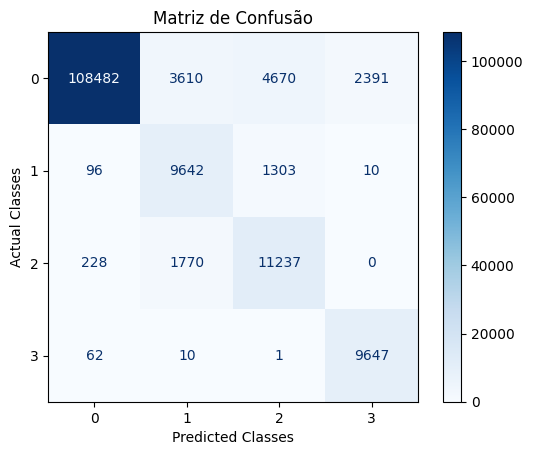

In [12]:
cm_rf.plot(number_label=True, title="Matriz de Confusão", cmap=plt.cm.Blues) # type: ignore

## 4. Treino e teste do Gausian Naive Bayes

In [13]:
nb = GaussianNB()
metrics_nb, y_pred = benchmark(nb, X_train_res, y_train_res, X_test_pca)

### 4.1 Métricas de desempenho do Gaussian Naive Bayes

In [14]:
cm_nb = ConfusionMatrix(actual_vector=y_test,predict_vector=y_pred)

weighted_metrics_nb = get_weighted_metrics(cm_nb)
print_weighted_metrics(weighted_metrics_nb)

Métrica,Valor
Probabilidade de detecção,0.4621
Probabilidade de alarme falso,0.2645
Especificidade,0.7355
Taxa de Erro,0.4169
Acurácia,0.5831
F1-Score,0.5271
Coeficiente MCC,0.1596
Probabilidade de detecção falsa,0.5379


### 4.2 Matriz de confusão

<Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

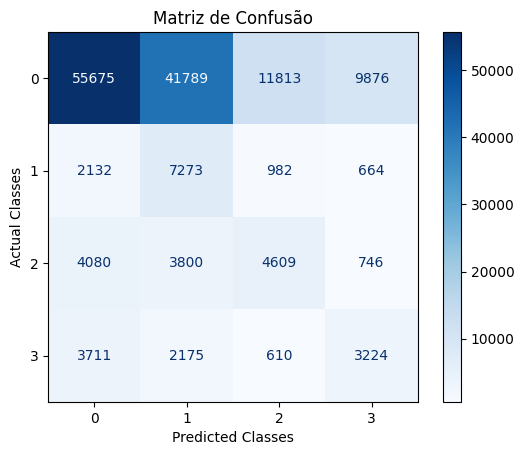

In [15]:
cm_nb.plot(number_label=True, title="Matriz de Confusão", cmap=plt.cm.Blues) # type: ignore

## 5. Treino e teste do SVM

In [16]:
linearsvc = LinearSVC()

metrics_svc, y_pred = benchmark(linearsvc, X_train_res, y_train_res, X_test_pca)

### 5.1 Métricas de desempenho do SVM

In [17]:
plot_performance_metrics(metrics_svc, "Métricas de desempenho do SVM")

Train time,Train peak memory,Predict time,Predict peak memory
961.38 ms,1.45 MiB,12.82 ms,9.41 MiB


In [18]:
cm_svc = ConfusionMatrix(actual_vector=y_test,predict_vector=y_pred)

weighted_metrics_svc = get_weighted_metrics(cm_svc)
print_weighted_metrics(weighted_metrics_svc)

Métrica,Valor
Probabilidade de detecção,0.3768
Probabilidade de alarme falso,0.1595
Especificidade,0.8405
Taxa de Erro,0.4675
Acurácia,0.5325
F1-Score,0.4450
Coeficiente MCC,0.1806
Probabilidade de detecção falsa,0.6232


### 5.2 Matriz de confusão

<Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

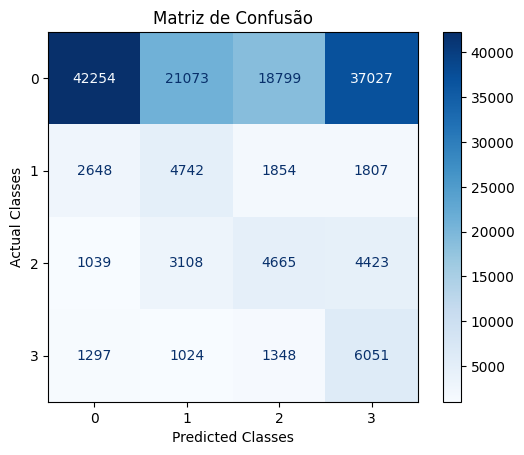

In [19]:
cm_svc.plot(number_label=True, title="Matriz de Confusão", cmap=plt.cm.Blues) # type: ignore

## 8. Métricas dos algoritmos

### 8.1. Probabilidade de detecção e acurácia

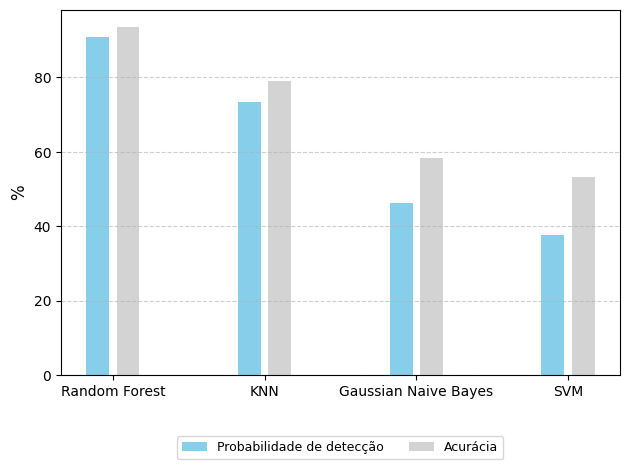

In [20]:
results = {
    "Random Forest": {"tpr": weighted_metrics_rf['TPR'], "acc": weighted_metrics_rf['ACC'],
                      "pmd": weighted_metrics_rf['PMD'], "pfa": weighted_metrics_rf['FPR'],
                      "err": weighted_metrics_rf['ERR'], "mcc": weighted_metrics_rf['MCC'],
                      "f1": weighted_metrics_rf['F1'], "tnr": weighted_metrics_rf['TNR']},

    "KNN": {"tpr": weighted_metrics_knn['TPR'], "acc": weighted_metrics_knn['ACC'],
            "pmd": weighted_metrics_knn['PMD'], "pfa": weighted_metrics_knn['FPR'],
            "err": weighted_metrics_knn['ERR'], "mcc": weighted_metrics_knn['MCC'],
            "f1": weighted_metrics_knn['F1'], "tnr": weighted_metrics_knn['TNR']},

    "Gaussian Naive Bayes": {"tpr": weighted_metrics_nb['TPR'], "acc": weighted_metrics_nb['ACC'],
                             "pmd": weighted_metrics_nb['PMD'], "pfa": weighted_metrics_nb['FPR'],
                             "err": weighted_metrics_nb['ERR'], "mcc": weighted_metrics_nb['MCC'],
                             "f1": weighted_metrics_nb['F1'], "tnr": weighted_metrics_nb['TNR']},
    "SVM": {"tpr": weighted_metrics_svc['TPR'], "acc": weighted_metrics_svc['ACC'],
            "pmd": weighted_metrics_svc['PMD'], "pfa": weighted_metrics_svc['FPR'],
            "err": weighted_metrics_svc['ERR'], "mcc": weighted_metrics_svc['MCC'],
            "f1": weighted_metrics_svc['F1'], "tnr": weighted_metrics_svc['TNR']},
}

plot_metrics_graphic(results, metrics_to_plot=["tpr", "acc"])

### 8.2. Probabilidade de detecções falsas e alarmes falsos

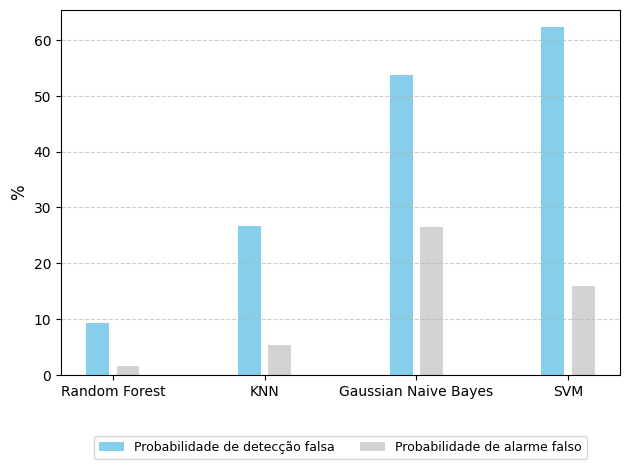

In [21]:
plot_metrics_graphic(results, metrics_to_plot=["pmd", "pfa"])

### 8.3 Métricas gerais

Visualização em tabela, ordenado pelo algoritmo com a maior probabilidade de detecção.

Em seguida, visualização em tabela, ordenado pelo algoritmo com o menor tempo de treinamento

In [22]:
df = pd.DataFrame(results).T.reset_index()
df.columns = ["Algoritmo", "Probabilidade de detecção",
              "Acurácia", "Probabilidade de detecção falsa",
              "Probabilidade de alarme falso", "Taxa de Erro", "Coeficiente MCC", "F1-Score", "Especificidade"]


for col in ["Probabilidade de detecção",
              "Acurácia", "Probabilidade de detecção falsa",
              "Probabilidade de alarme falso", "Taxa de Erro", "Coeficiente MCC", "F1-Score", "Especificidade"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[["Probabilidade de detecção",
              "Acurácia", "Probabilidade de detecção falsa",
              "Probabilidade de alarme falso", "Taxa de Erro"]] *= 100

df = df.round(2)
df = df.sort_values(by="Probabilidade de detecção", ascending=False).reset_index(drop=True)

df = df.style.hide(axis="index").format({
    "Probabilidade de detecção": "{:.2f}%",
    "Acurácia": "{:.2f}%",
    "Probabilidade de detecção falsa": "{:.2f}%",
    "Probabilidade de alarme falso": "{:.2f}%",
    "Taxa de Erro": "{:.2f}%",
})

df


Algoritmo,Probabilidade de detecção,Acurácia,Probabilidade de detecção falsa,Probabilidade de alarme falso,Taxa de Erro,Coeficiente MCC,F1-Score,Especificidade
Random Forest,90.76%,93.51%,9.24%,1.63%,6.49%,0.810000,0.910000,0.980000
KNN,73.32%,78.96%,26.68%,5.37%,21.04%,0.550000,0.760000,0.950000
Gaussian Naive Bayes,46.21%,58.31%,53.79%,26.45%,41.69%,0.160000,0.530000,0.740000
SVM,37.68%,53.25%,62.32%,15.95%,46.75%,0.180000,0.450000,0.840000


In [23]:
performance_results = {
    "Random Forest": {"Train time": metrics_rf['train_time_ms'], "Train peak memory": metrics_rf['train_peak_memory_MiB'],
                      "Predict time": metrics_rf['predict_time_ms'], "Predict peak memory": metrics_rf['predict_peak_memory_MiB']},

    "KNN": {"Train time": metrics_knn['train_time_ms'], "Train peak memory": metrics_knn['train_peak_memory_MiB'],
            "Predict time": metrics_knn['predict_time_ms'], "Predict peak memory": metrics_knn['predict_peak_memory_MiB']},

    "Gaussian Naive Bayes": {"Train time": metrics_nb['train_time_ms'], "Train peak memory": metrics_nb['train_peak_memory_MiB'],
                             "Predict time": metrics_nb['predict_time_ms'], "Predict peak memory": metrics_nb['predict_peak_memory_MiB']},
        "SVM": {"Train time": metrics_svc['train_time_ms'], "Train peak memory": metrics_svc['train_peak_memory_MiB'],
                "Predict time": metrics_svc['predict_time_ms'], "Predict peak memory": metrics_svc['predict_peak_memory_MiB']},
}


df = pd.DataFrame(performance_results).T.reset_index()
df.columns = ["Algoritmo", "Tempo de treinamento", "Uso de memória (treinamento)",  "Tempo de predição", "Uso de memória (predição)"]

df = df.round(2)
df = df.sort_values(by="Tempo de treinamento", ascending=True).reset_index(drop=True)

df = df.style.hide(axis="index").format({
     "Tempo de treinamento": "{:.2f} ms",
     "Uso de memória (treinamento)": "{:.2f} MiB",
     "Tempo de predição": "{:.2f} ms",
     "Uso de memória (predição)": "{:.2f} MiB"
})

df

Algoritmo,Tempo de treinamento,Uso de memória (treinamento),Tempo de predição,Uso de memória (predição)
Gaussian Naive Bayes,304.37 ms,8.92 MiB,80.43 ms,33.95 MiB
KNN,429.74 ms,4.18 MiB,9338.96 ms,25.39 MiB
SVM,961.38 ms,1.45 MiB,12.82 ms,9.41 MiB
Random Forest,47289.56 ms,11.84 MiB,1652.37 ms,18.13 MiB
